### 목표 : 부족한 피쳐를 조합 생성하여 모델 성능 향상

-   특성공학 => 피쳐 추출/선택/생성
-   비선형의 데이터에 대한 피쳐 생성 ==> 곡선형태의 회귀선 수식
-   모듈 : sklearn.preprocessing 내에 포함
-   데이터 : fish.csv
-   피쳐 : Perch의 Height, length, width
-   타겟 : Perch의 Weight
-   학습유형 : 지도학습


[1] 전처리 피쳐 조합 생성 살펴보기


In [1]:
# 모듈 로딩
from sklearnex import patch_sklearn

patch_sklearn()
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# 인스턴스 생성
poly = PolynomialFeatures(include_bias=False)


In [3]:
poly.fit([[2, 3]])


PolynomialFeatures(include_bias=False)

In [4]:
poly.transform([[2, 3]])


array([[2., 3., 4., 6., 9.]])

In [5]:
poly = PolynomialFeatures(include_bias=False, degree=5)
poly.fit([[2, 3]])


PolynomialFeatures(degree=5, include_bias=False)

In [6]:
poly.transform([[2, 3]])


array([[  2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.,  16.,  24.,
         36.,  54.,  81.,  32.,  48.,  72., 108., 162., 243.]])

In [7]:
poly.get_feature_names_out()


array(['x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2',
       'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3', 'x1^4', 'x0^5',
       'x0^4 x1', 'x0^3 x1^2', 'x0^2 x1^3', 'x0 x1^4', 'x1^5'],
      dtype=object)

[2] Perch 데이터를 최대한 만족하는 회귀선을 찾기


[2-1] 모듈 로딩 및 데이터 준비 <hr>


In [8]:
import pandas as pd
import matplotlib.pyplot as plt


In [9]:
# 데이터 준비
data_file = "../data/fish.csv"

dataDF = pd.read_csv(data_file)
dataDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   159 non-null    object 
 1   Weight    159 non-null    float64
 2   Length    159 non-null    float64
 3   Diagonal  159 non-null    float64
 4   Height    159 non-null    float64
 5   Width     159 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB


In [10]:
dataDF.drop("Diagonal", axis="columns", inplace=True)


In [11]:
dataDF.head(2)


,Species,Weight,Length,Height,Width
0,Bream,242.0,25.4,11.52,4.0200
1,Bream,290.0,26.3,12.48,4.3056


In [12]:
perchDF = dataDF[dataDF.Species == "Perch"]


In [13]:
perchDF = perchDF.drop("Species", axis="columns").copy()


In [14]:
perchDF.head(2)


,Weight,Length,Height,Width
72,5.9,8.4,2.112,1.4080
73,32.0,13.7,3.528,1.9992


In [15]:
# 행 인덱스 초기화
perchDF.reset_index(drop=True, inplace=True)
perchDF.head(2)


,Weight,Length,Height,Width
0,5.9,8.4,2.112,1.4080
1,32.0,13.7,3.528,1.9992


[2-2] 데이터 확인 <hr>

-   학습 유형 결정 위한 단계
-   피쳐 스케일링 진행 여부 체크


In [16]:
def print_feature(nrows, ncols, df, target, features, corrs):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(df[target], df[features[idx]], label=f"{corrs[idx]:.2}")
        plt.legend()
        plt.xlabel(target)
        plt.ylabel(features[idx])
    plt.tight_layout()
    plt.show()


C:\Users\KDP-25\AppData\Local\Temp\ipykernel_12072\3877667237.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(df[target], df[features[idx]], label=f"{corrs[idx]:.2}")


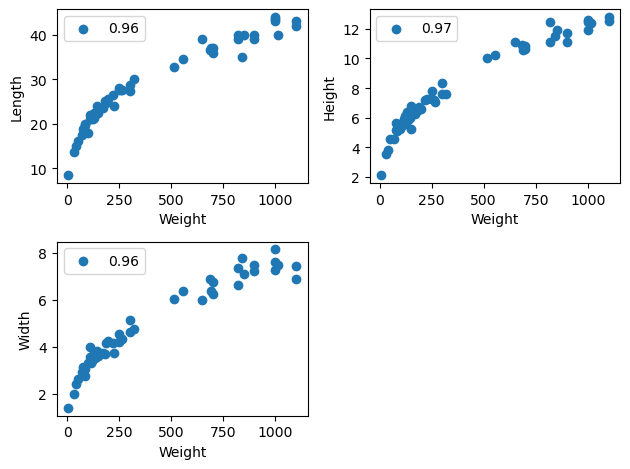

In [17]:
target = perchDF.columns[0]
feature = perchDF.columns[1:]
corr = perchDF.corr()[target][1:]
print_feature(2, 2, perchDF, target, feature, corr)


In [18]:
featureDF = perchDF[feature]
targetDF = perchDF[target]


In [21]:
model = LinearRegression()
poly = PolynomialFeatures()
scaler = StandardScaler()


In [39]:
scoreDict = {}
i = 0
for num in range(10000):
    x_train, x_test, y_train, y_test = train_test_split(
        featureDF, targetDF, test_size=0.2, random_state=num
    )
    poly.fit(x_train)
    poly_x_train = poly.transform(x_train)
    poly_x_test = poly.transform(x_test)
    scaler.fit(poly_x_train)
    scaled_x_train = scaler.transform(poly_x_train)
    scaled_x_test = scaler.transform(poly_x_test)

    model.fit(scaled_x_train, y_train)
    train_score = model.score(scaled_x_train, y_train)
    test_score = model.score(scaled_x_test, y_test)
    diff = abs(test_score - train_score)

    if diff < 0.03 and test_score > train_score:
        y_pre = model.predict(scaled_x_test)
        mae = mean_absolute_error(y_test, y_pre)
        mse = mean_squared_error(y_test, y_pre)
        rmse = mean_squared_error(y_test, y_pre, squared=False)
        r2 = r2_score(y_test, y_pre)
        scoreDict[i] = (num, train_score, test_score, diff, mae, mse, rmse, r2)
        i += 1


In [40]:
scoreDF = pd.DataFrame(scoreDict).T
scoreDF.columns = [
    "random_state",
    "train_score",
    "test_score",
    "diff",
    "mae",
    "mse",
    "rmse",
    "r2",
]
scoreDF["diff"] = (scoreDF["test_score"] - scoreDF["train_score"]).abs()


In [41]:
scoreDF


,random_state,train_score,test_score,diff,mae,mse,rmse,r2
0,8.0,0.988231,0.992651,0.004420,19.674878,676.500879,26.009631,0.992651
1,9.0,0.987943,0.994546,0.006603,12.182219,234.642477,15.318044,0.994546
2,16.0,0.988100,0.996537,0.008437,12.850586,253.480764,15.921079,0.996537
3,24.0,0.988341,0.991696,0.003355,19.931623,748.264955,27.354432,0.991696
4,48.0,0.988087,0.989064,0.000977,24.597988,1236.921890,35.169900,0.989064
...,...,...,...,...,...,...,...,...
1138,9965.0,0.987884,0.995146,0.007262,15.000273,494.398692,22.235078,0.995146
1139,9984.0,0.987602,0.993780,0.006178,13.638510,382.660237,19.561703,0.993780
1140,9990.0,0.988676,0.991604,0.002928,15.088084,341.531516,18.480571,0.991604
1141,9992.0,0.988308,0.990107,0.001799,16.722001,406.435762,20.160252,0.990107


In [44]:
scoreDF[scoreDF["test_score"] > 0.9].sort_values(
    by=["test_score", "diff"], ascending=[False, True]
)[:1]


,random_state,train_score,test_score,diff,mae,mse,rmse,r2
796,6844.0,0.987342,0.997539,0.010196,8.796903,157.226554,12.539001,0.997539


In [45]:
x_train, x_test, y_train, y_test = train_test_split(
    featureDF, targetDF, test_size=0.2, random_state=6844
)
scaler.fit(x_train)
scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

model.fit(scaled_x_train, y_train)
train_score = model.score(scaled_x_train, y_train)
test_score = model.score(scaled_x_test, y_test)
diff = abs(test_score - train_score)

y_pre = model.predict(scaled_x_test)
mae = mean_absolute_error(y_test, y_pre)
mse = mean_squared_error(y_test, y_pre)
rmse = mean_squared_error(y_test, y_pre, squared=False)
r2 = r2_score(y_test, y_pre)

pd.DataFrame(
    [(6844, train_score, test_score, diff, mae, mse, rmse, r2)], columns=scoreDF.columns
)


,random_state,train_score,test_score,diff,mae,mse,rmse,r2
0,6844,0.935841,0.957128,0.021286,39.932289,2738.457899,52.330277,0.957128
